# TP4 M1 info -- Introduction au traitement du signal, aux signaux sonores et aux images -- A la découverte des signaux audio

**But du TP** :
* obtenir une représentation spectrale et cepstrale
* faire l'extraction des paramètres temporels
* réaliser une représentation en spectrogramme

**Avertissement** :
Il peut être tentant d'utiliser ChatGPT ou d'autres outils d'écriture de code. Mais il ne s'agit que d'une introduction, couvrant des concepts très simples pour manipuler des fichiers. Nous vous recommandons fortement de ne pas l'utiliser. Vous aurez suffisamment de temps pour réaliser par vous-même les quelques fonctions qui vous sont demandées. Et vous les assimilerez bien mieux. Vous devrez réutiliser ces fonctions pour l'évaluation, ce qui vous confrontera à de nouvelles données. Essayez donc de rendre ces fonctions aussi générales que possible.

**Astuces**:
* Essayez de faire fonctionner vos algorithmes sur n'importe quelle taille d'image.
* N'hésitez pas à créer des fonctions pour chaque partie des traitements.

In [ ]:
# OS setup
!cat /etc/os-release
!apt-get install -q=2 tree

# Data loading
!git clone https://gitlab.com/jeromefarinas/tp-m1-ts.git

In [2]:
# Some usefull library
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
from IPython.display import Audio
import scipy.io.wavfile as wav

##Paramétrage spectral et cepstral

En utilisant les échantillons 27800 à 28823 du fichier L1.wav (/contents/tp-m1-ts/tp4/L1.wav), afficher sur une seule figure (utiliser [matplotlib.pyplot.subplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html), [numpy.log](https://numpy.org/doc/stable/reference/generated/numpy.log.html), [numpy.hamming](https://numpy.org/doc/stable/reference/generated/numpy.hamming.html), [numpy.fft.fft](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html), [abs](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html)...) :
- l'extrait du signal, composé de 1024 points,
- le spectre (après fenêtrage de Hamming),
- le cepstre (en effectuant une transformée de Fourier sur le logarithme du spectre).

Affichez, pour chaque tracé, le titre, le nom des axes et fixez l'abscisse en secondes ou en Hertz selon le cas.

In [18]:
# A vous...

fs, sound = wav.read('tp-m1-ts/tp4/L1.wav')
excerpt = sound[27800:28824]

In [19]:
window = np.hamming(len(excerpt))
windowed_excerpt = excerpt * window

spectrum = np.fft.fft(windowed_excerpt)
freq = np.fft.fftfreq(len(excerpt), d=1/fs)

In [21]:
cepstrum = np.fft.ifft(np.log(np.abs(spectrum)))
freq_cep = np.arange(len(cepstrum)) / fs

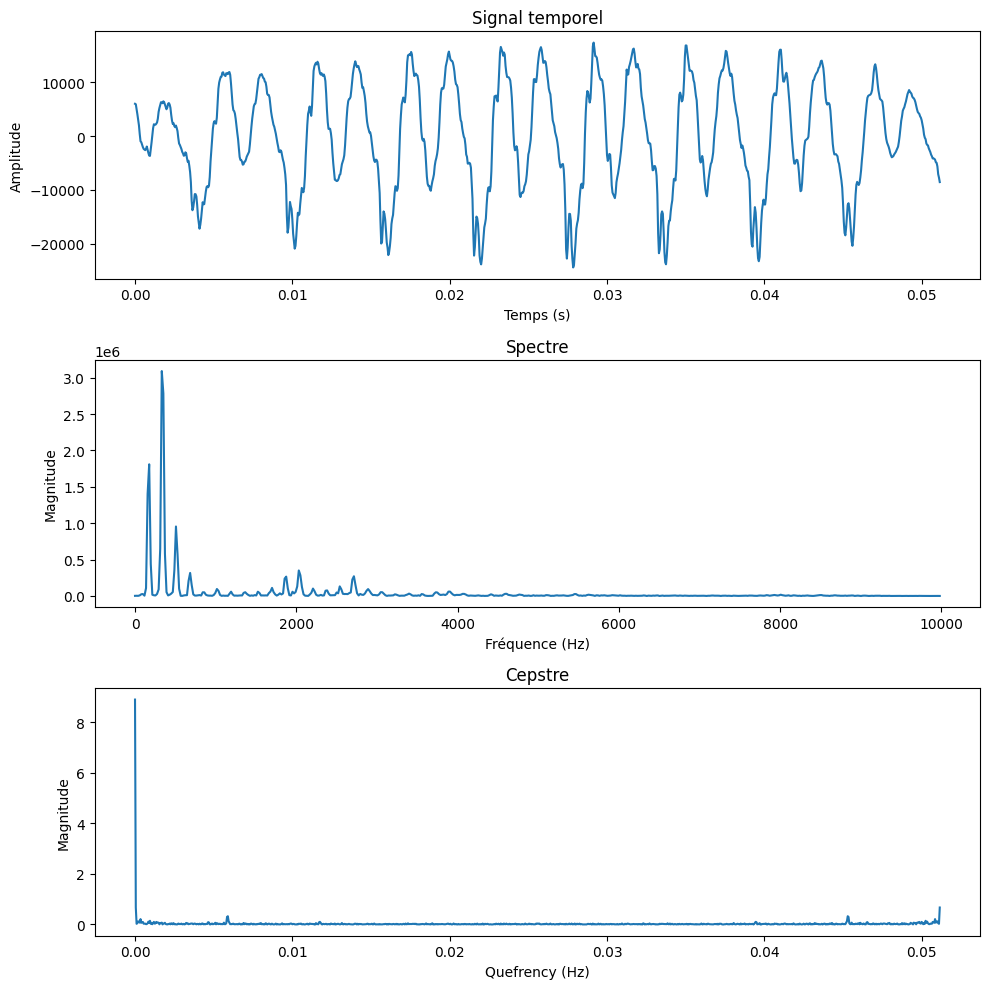

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

time = np.arange(len(excerpt)) / fs
ax1.plot(time, excerpt)
ax1.set_title('Signal temporel')
ax1.set_xlabel('Temps (s)')
ax1.set_ylabel('Amplitude')

ax2.plot(freq[:len(freq) // 2], np.abs(spectrum[:len(freq) // 2]))
ax2.set_title('Spectre')
ax2.set_xlabel('Fréquence (Hz)')
ax2.set_ylabel('Magnitude')

ax3.plot(freq_cep, np.abs(cepstrum))
ax3.set_title('Cepstre')
ax3.set_xlabel('Quefrency (Hz)')
ax3.set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

# Extraction des paramètres temporels

**Conseil** : Passez les échantillons en nombre réels [-1,1] pour effectuer les calculs suivants.

* Utilisez la fonction d'énergie vue dans TD pour calculer l'énergie à court terme d'un signal en fonction de la taille de la fenêtre d'analyse.

In [24]:
# A vous...
def short_time_energy(signal, window_size):
    energy = []
    for i in range(0, len(signal), window_size):
        energy.append(np.sum(np.square(signal[i:i+window_size])))
    return energy

* Sur la base de la fonction précédente, écrivez une fonction zcr qui calcule le taux de passage à zéro (ZCR) d'un signal passé en paramètre.

**Rappel de cours** : pour une fenêtre à l'instant t,
$ZCR(t) = \frac{1}{2N} \sum_{n=1}^{N}\left | sign(x_{n}) - sign(x_{n-1}) \right |$
Vous pouvez utiliser la fonction [numpy.sign](https://numpy.org/doc/stable/reference/generated/numpy.sign.html).



In [27]:
def zcr(signal, window_size):
    zcr = []
    for i in range(0, len(signal), window_size):
        window = signal[i:i+window_size]
        signs = np.sign(window)
        zcr_window = np.sum(np.abs(signs[1:] - signs[:-1])) / (2 * window_size)
        zcr.append(zcr_window)
    return zcr

* Puis, affichez sur une même figure le signal, la courbe de l'énergie et la courbe du ZCR. Qu'observez-vous ? En déduire l'intérêt de ces paramètres.

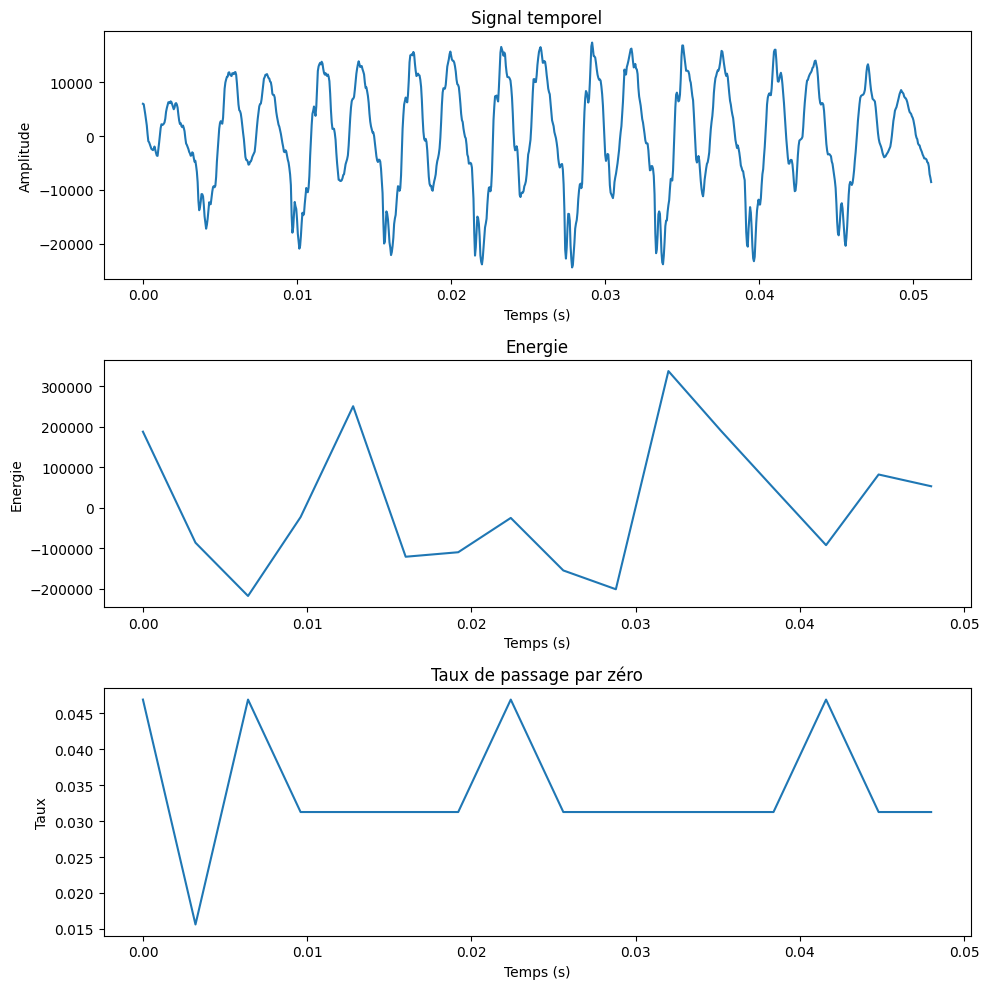

In [31]:
# A vous...

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

time = np.arange(len(excerpt)) / fs
ax1.plot(time, excerpt)
ax1.set_title('Signal temporel')
ax1.set_xlabel('Temps (s)')
ax1.set_ylabel('Amplitude')

energy = short_time_energy(excerpt, 64)
time_energy = np.arange(len(energy)) * 64 / fs
ax2.plot(time_energy, energy)
ax2.set_title('Energie')
ax2.set_xlabel('Temps (s)')
ax2.set_ylabel('Energie')

zcr_values = zcr(excerpt, 64)
time_zcr = np.arange(len(zcr_values)) * 64 / fs
ax3.plot(time_zcr, zcr_values)
ax3.set_title('Taux de passage par zéro')
ax3.set_xlabel('Temps (s)')
ax3.set_ylabel('Taux')

plt.tight_layout()
plt.show()

Le niveau d'énergie augmente juste après les augmentations du ZCR

# Représentation du spectrogramme

* Reprendre la fonction spectro vue en TD, qui calcule le spectrogramme d'un signal en fonction de la taille de la fenêtre d'analyse.

In [52]:
# A vous...
def spectro(signal, fs, window_size):
    noverlap = window_size // 2
    hop_size = window_size - noverlap

    pad_samples = window_size - (len(signal) - window_size) % hop_size
    padded_signal = np.pad(signal, (0, pad_samples), mode='constant')

    num_windows = (len(padded_signal) - window_size) // hop_size + 1
    window = np.hanning(window_size)
    spectrogram = np.zeros((window_size // 2 + 1, num_windows))

    for i in range(num_windows):
        start = i * hop_size
        end = start + window_size
        windowed_signal = padded_signal[start:end] * window
        spectrum = np.fft.fft(windowed_signal)[:window_size // 2 + 1]
        spectrogram[:, i] = np.abs(spectrum)
    
    time_bins = np.arange(num_windows) * hop_size / fs
    freq_bins = np.fft.fftfreq(window_size, d=1/fs)[:window_size // 2 + 1]
    return spectrogram, time_bins, freq_bins


* Afficher le spectrogramme du fichier L1.wav sous forme d'image à l'aide de la fonction suivante : [matplotlib.pyplot.plt.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)(spectrogram, extent=\[0, **time**, 0, **freq**\], aspect="auto", origin="lower"). Les limites **time** et **freq** doivent être calculées par vos soins.

In [53]:
ssound = sound.astype(np.float32) / np.iinfo(sound.dtype).max
window_size = 1024

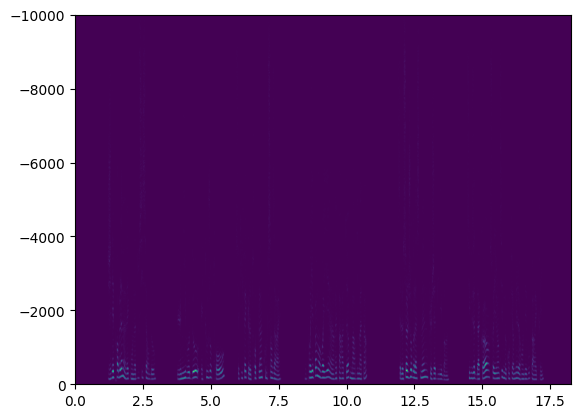

In [55]:
# A vous...
spectrogram, time_bins, freq_bins = spectro(ssound, fs, window_size)

time_limit = time_bins[-1]
freq_limit = freq_bins[-1]

plt.imshow(spectrogram, extent=[0, time_bins[-1], 0, freq_bins[-1]], aspect='auto', origin='lower')

* Comparez votre fonction spectro avec matplotlib.pyplot.specgram(sig, Fs=fs, window=ham1024, NFFT=1024). Que remarquez-vous ?



(array([[7.17706293e-14, 2.88398021e-12, 3.06953404e-16, ...,
         5.10920817e-13, 2.25778446e-12, 1.31367157e-13],
        [5.72423948e-11, 2.99889746e-11, 3.73615956e-11, ...,
         4.09591615e-11, 5.52183312e-11, 3.76626019e-11],
        [2.18900810e-09, 1.20757421e-09, 2.42387597e-09, ...,
         1.55299093e-09, 1.39451627e-09, 1.46369510e-09],
        ...,
        [5.68623448e-11, 4.98221482e-13, 7.02825837e-11, ...,
         3.23317107e-11, 2.43426416e-13, 1.21185363e-10],
        [1.38854280e-10, 7.30967931e-12, 1.51911786e-11, ...,
         7.34560941e-11, 9.53554745e-11, 7.64410416e-11],
        [9.15027893e-11, 5.97145109e-13, 6.80355938e-12, ...,
         3.23295333e-11, 1.02508359e-10, 5.74261930e-11]]),
 array([    0.     ,    19.53125,    39.0625 ,    58.59375,    78.125  ,
           97.65625,   117.1875 ,   136.71875,   156.25   ,   175.78125,
          195.3125 ,   214.84375,   234.375  ,   253.90625,   273.4375 ,
          292.96875,   312.5    ,   332.03125,

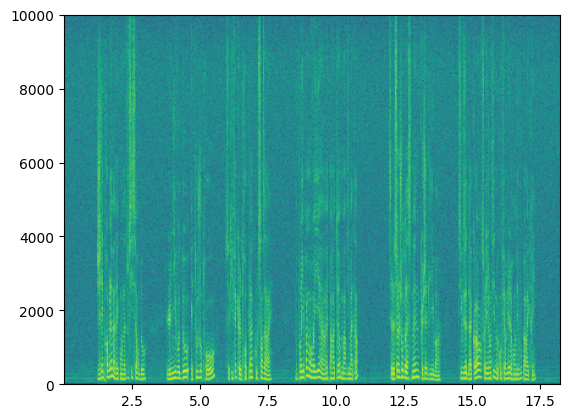

In [56]:
# A vous...
plt.specgram(ssound, NFFT=1024, Fs=fs)

Vos commentaires...

Les deux se ressemblent fortement dans les valeurs en bas, mais la première méthode perd en qualité dans les hautes fréquences.